# Teoretiska frågor

1. En relationsdatabas fungerar på det sätt att man ordnar data i olika tabeller, och man skapar relationer mellan dessa genom "keys" som gör att man kan använda datan i hela databasen även om det är uppdelat, genom att knyta dessa relationer och kunna koppla data ihop med varandra.

2. CRUD-flödet (Create Read Update Delete) är flödet man jobbar i en databas där man skapar data i en databas (t.ex. INSERT INTO), man läser av och hämtar data (t.ex. med SELECT statements), man uppdaterar datan i databasen (t.ex. med UPDATE) och man tar bort data i databasen (t.ex. DELETE där man tar bort datan eller DROP, när man ska ta bort själva tabellerna och databaserna, alltså inte bara datan utan strukturen med).

3. Joins är sätt att skapa en interaktion mellan tabeller för att kunna manipulera och redovisa olika resultat som man vill ha involverande flera tabeller (man kan också göra selfjoins).
En inner join tar alla rader som båda tabellerna delar, dem som inte finns i båda exkluderas helt.
En left join tar alla rader från förstnämnda tabellen i koden(the left table) och endast de rader från högra tabellen som matchar. De rader från högra som inte matchar kommer endast visa NULL.

4. När man indexerar en tabell, väljer man en eller flera kolumner att indexera datan efter, där man sorterar efter dem. Det gör att queries går snabbare, då den inte behöver söka igenom all data för att hitta, men det gör edits och writes långsammare, för den måste uppdatera samtliga index.

5. En vy är en skapad tabell, men inte en konventionell en. En vy lagrar nämligen inte data, utan den presenterar bara data från tabeller genom en SELECT statement man sparat i vyn. Används för att kunnna få fram specifik information utan att behöva skriva kod varje gång.

6. En lagrad procedur är ett återanvändbart kodblock som utför de operationer man skapat den för och gör samma action varje gång. Detta hjälper med att öka prestandan, minimera fel för att man inte behöver skriva ut komplexa operationer flera gånger och gör koden mer lättläslig.

In [55]:
from sqlalchemy import create_engine, URL, inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [56]:
SERVER = 'localhost'
DATABASE = 'AdventureWorks2022'

connection_string = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={SERVER};DATABASE={DATABASE};Trusted_Connection=yes;Encrypt=no'

connection_url = URL.create('mssql+pyodbc', query={'odbc_connect': connection_string})

engine = create_engine(connection_url)

connection = engine.connect()

In [57]:
schema_tables = """
SELECT COUNT(TABLE_NAME) AS Amount_of_tables, TABLE_SCHEMA FROM INFORMATION_SCHEMA.TABLES
WHERE TABLE_TYPE LIKE 'BASE%' AND TABLE_SCHEMA NOT LIKE '%dbo%'
GROUP BY TABLE_SCHEMA
"""

overview = pd.read_sql(sql=schema_tables, con=connection)

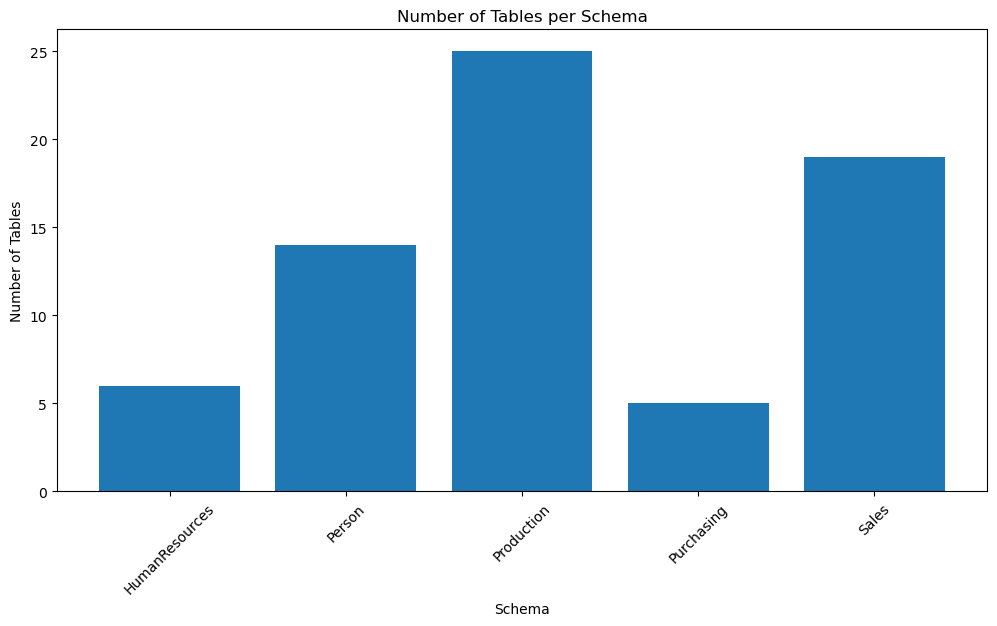

   Amount_of_tables    TABLE_SCHEMA
0                 6  HumanResources
1                14          Person
2                25      Production
3                 5      Purchasing
4                19           Sales


In [58]:
plt.figure(figsize=(12, 6))
plt.bar(overview['TABLE_SCHEMA'], overview['Amount_of_tables'])

plt.xlabel('Schema')  
plt.ylabel('Number of Tables') 
plt.title('Number of Tables per Schema')

plt.xticks(rotation=45)

plt.show()
print(overview.head())


Som vi ser ovan, innehåller databasen 5 olika specifika schemas där datan ligger.
AdventureWorks är ett företag som producerar och säljer cyklar, cykeldelar, cykeltillbehör och kläder för cyklister.
Dem säljer både till återförsäljare och privatpersoner.

Person innehåller personuppgifter som insamlats av företaget, från kunder och anställda. Production innehåller all info om själva produkterna. Purchasing innehåller information angående inköp av råmaterial för produkterna AdventureWorks producerar och dem som vi köper från. Sales innehåller försäljningsuppgifter, inkluderat säljare och deras ansvarsområden samt försäljning av produkter.


Jag vill titta närmare på HumanResources och leta fram lönerna.

I koden nedan tar jag fram all data jag vill ha från databasen, aggregerat i SQL istället för Python. Jag gör detta för att det är mer tidseffektivt att göra i SQL stora beräkningar, då den är lämpad för detta.

In [59]:
data_w_ci ="""--To get the latest pay rate per employee
WITH CTE_Date
AS 
(	
SELECT MAX(EPH.RateChangeDate) AS Latest_Date
				,EDH.BusinessEntityID
				,E.SalariedFlag
FROM HumanResources.EmployeePayHistory AS EPH
    INNER JOIN HumanResources.EmployeeDepartmentHistory AS EDH
	ON EPH.BusinessEntityID = EDH.BusinessEntityID
	INNER JOIN HumanResources.Employee AS E
	ON EDH.BusinessEntityID = E.BusinessEntityID
GROUP BY EDH.BusinessEntityID, E.SalariedFlag
)

--Calculating 
SELECT DISTINCT
	   D.Name AS Department_name  
       , MIN(Rate) OVER (PARTITION BY EDH.DepartmentID, CTE.SalariedFlag) AS Min_salary  
       , MAX(Rate) OVER (PARTITION BY EDH.DepartmentID, CTE.SalariedFlag) AS Max_salary  
       , AVG(Rate) OVER (PARTITION BY EDH.DepartmentID, CTE.SalariedFlag) AS Avg_salary  
       , COUNT(EDH.BusinessEntityID) OVER (PARTITION BY EDH.DepartmentID, CTE.SalariedFlag) AS Employees_per_dept
	   , CASE WHEN CTE.SalariedFlag = 1 THEN 'Salaried Employee'
		 WHEN CTE.SalariedFlag = 0 THEN 'Hourly Employee'
		 END AS Type_of_employee
   	   , STDEVP(Rate) OVER (PARTITION BY EDH.DepartmentID, CTE.SalariedFlag) AS StdDev_salary
       , AVG(Rate) OVER (PARTITION BY EDH.DepartmentID, CTE.SalariedFlag) 
       + (1.96 * (STDEVP(Rate) OVER (PARTITION BY EDH.DepartmentID, CTE.SalariedFlag) / 
       SQRT(COUNT(EDH.BusinessEntityID) OVER (PARTITION BY EDH.DepartmentID, CTE.SalariedFlag)))) AS CI_Upper
       , AVG(Rate) OVER (PARTITION BY EDH.DepartmentID, CTE.SalariedFlag) 
       - (1.96 * (STDEVP(Rate) OVER (PARTITION BY EDH.DepartmentID, CTE.SalariedFlag) / 
       SQRT(COUNT(EDH.BusinessEntityID) OVER (PARTITION BY EDH.DepartmentID, CTE.SalariedFlag)))) AS CI_Lower
   
FROM HumanResources.EmployeePayHistory AS EPH  
	INNER JOIN HumanResources.EmployeeDepartmentHistory AS EDH  
		ON EPH.BusinessEntityID = EDH.BusinessEntityID  
	INNER JOIN HumanResources.Department AS D  
		ON D.DepartmentID = EDH.DepartmentID  
	INNER JOIN CTE_Date AS CTE
		ON CTE.BusinessEntityID = EPH.BusinessEntityID AND CTE.Latest_Date = EPH.RateChangeDate
WHERE EDH.EndDate IS NULL
ORDER BY Department_name;
"""
ci_df = pd.read_sql(sql=data_w_ci, con=connection)

In [60]:
#För att visa att datan förts över korrekt från SQL.
ci_df.head(50)

,Department_name,Min_salary,Max_salary,Avg_salary,Employees_per_dept,Type_of_employee,StdDev_salary,CI_Upper,CI_Lower
0,Document Control,10.2500,17.7885,14.3884,5,Hourly Employee,3.397233,17.366206,11.410594
1,Engineering,32.6923,63.4615,40.1442,6,Salaried Employee,11.081170,49.010983,31.277417
2,Executive,60.0962,125.5000,92.7981,2,Salaried Employee,32.701900,138.120621,47.475579
3,Facilities and Maintenance,9.2500,9.7500,9.3500,5,Hourly Employee,0.200000,9.525308,9.174692
4,Facilities and Maintenance,20.4327,24.0385,22.2356,2,Salaried Employee,1.802900,24.734292,19.736908
5,Finance,13.4615,19.0000,18.0769,6,Hourly Employee,2.064077,19.728506,16.425294
6,Finance,26.4423,43.2692,32.7223,4,Salaried Employee,6.967196,39.550152,25.894448
7,Human Resources,13.9423,18.2692,16.2019,5,Hourly Employee,1.944580,17.906400,14.497400
8,Human Resources,27.1394,27.1394,27.1394,1,Salaried Employee,0.000000,27.139400,27.139400
9,Information Services,27.4038,50.4808,34.5853,8,Salaried Employee,8.021850,40.144159,29.026441


Om man kollar på avdelningarna som har både timlönsanställda(hädanefter kallat hourly) och fast månadslönsanställda(hädanefter kallat salaried), ser det ut som att chefsrollerna är dem som har salary, men icke-chef/ledarroller har hourly.
Det överensstämmer om man kollar på max lönen för hourly och min lönen för salaried på alla avdelningar. Den skillnaden är mestadels en markant skillnad, större än min-max skillnaden på hourly.

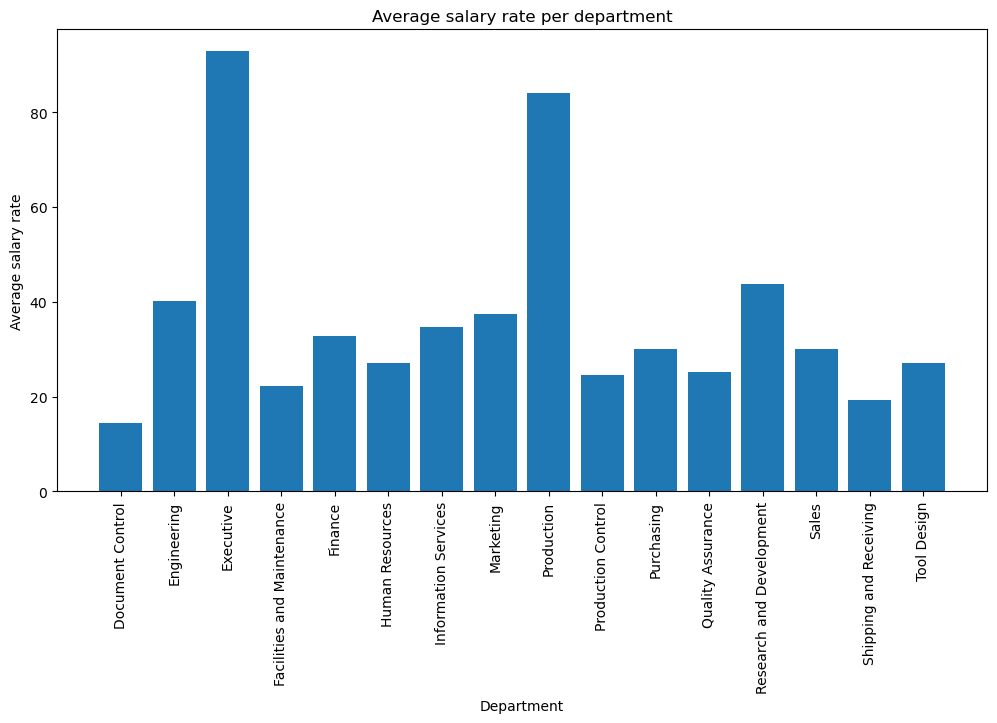

In [61]:
#Detta är figuren för att visa medellön per avdelning.
plt.figure(figsize=(12, 6))
plt.bar(ci_df['Department_name'], ci_df['Avg_salary'])


plt.xlabel('Department')  
plt.ylabel('Average salary rate')  
plt.title('Average salary rate per department')  

plt.xticks(rotation=90)


plt.show()

Som vi ser i ovan, är det stor skillnad på två av avdelningarnas medellön jämfört med resten.
Antal anställda per avdelning varierar. Jag vill se om denna skillnad per avdelning också är inom avdelningarna beroende på 
anställningsform.

Nedan gör jag en uppdelning på det med datan jag samlade till om de är timlön eller månadslön.
Jag inför här också konfidensintervall som visar hur stor sannolikhet att vi har hamnat inom det rätta medelvärdet.
Eftersom vissa avdelningar är mindre, visas konfidensintervallet som större, i t.ex. Executive avdelning, då spridningen på deras löner är väldigt stor, men det är endast två personer.

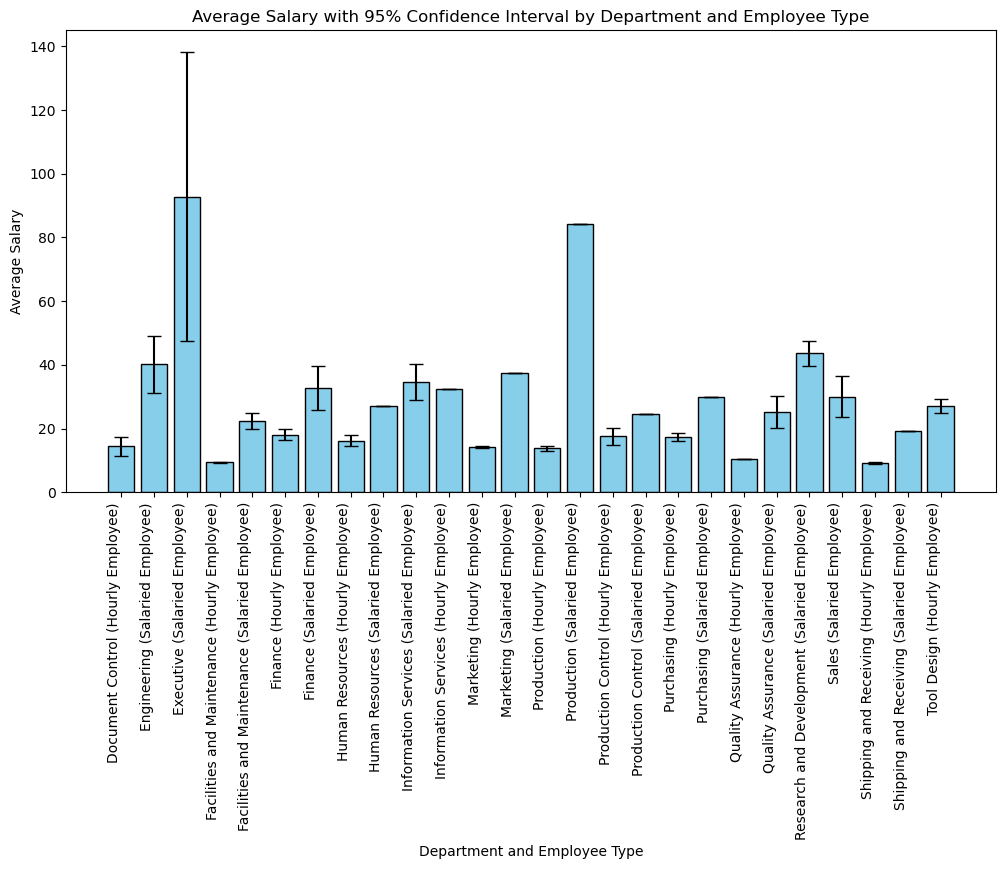

In [62]:
plt.figure(figsize=(12, 6))

#Tar fram datan från SQL queryn i dataframe.
x = ci_df['Department_name'] + ' (' + ci_df['Type_of_employee'] + ')'
y = ci_df['Avg_salary']
yerr = [ci_df['Avg_salary'] - ci_df['CI_Lower'], ci_df['CI_Upper'] - ci_df['Avg_salary']]  # Confidence Interval


plt.bar(x, y, yerr=yerr, capsize=5, color='skyblue', edgecolor='black')

plt.xlabel('Department and Employee Type')
plt.ylabel('Average Salary')
plt.title('Average Salary with 95% Confidence Interval by Department and Employee Type')
plt.xticks(rotation=90, ha='right') 

plt.show()


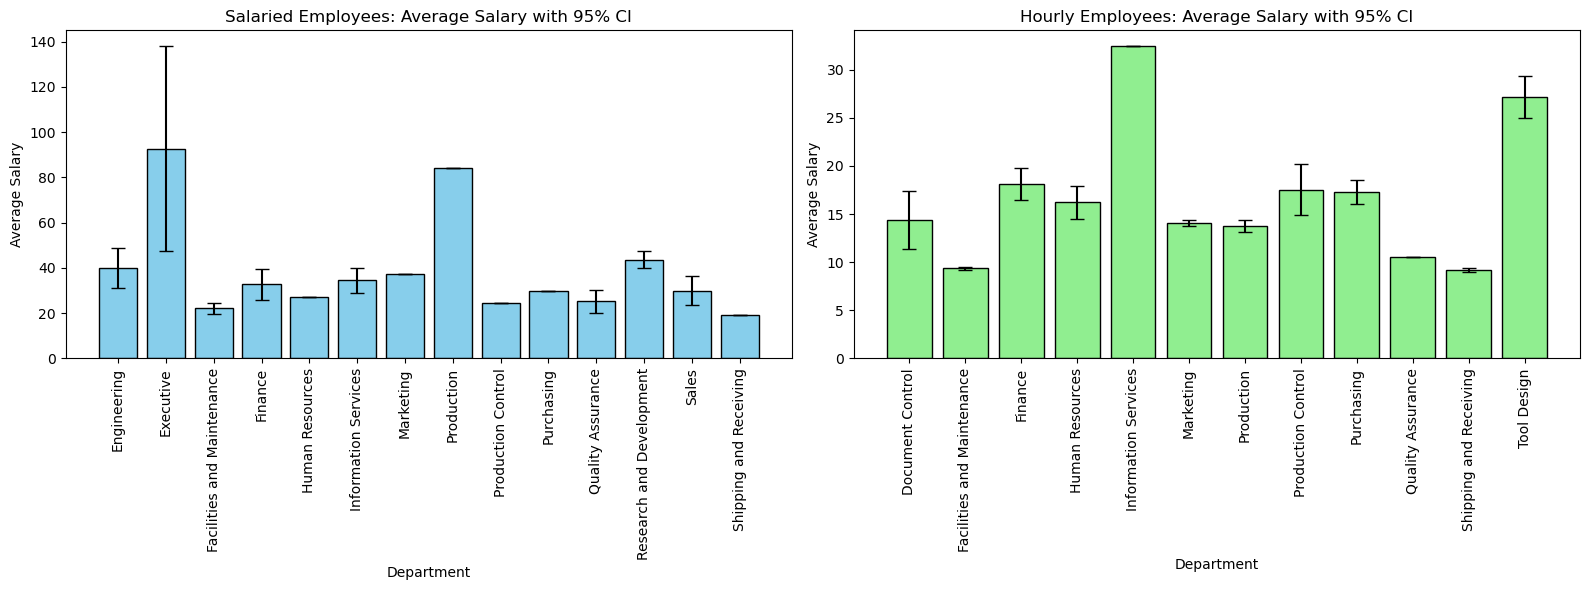

In [63]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

salaried_data = ci_df[ci_df['Type_of_employee'] == 'Salaried Employee']
hourly_data = ci_df[ci_df['Type_of_employee'] == 'Hourly Employee']

x_salaried = salaried_data['Department_name']
y_salaried = salaried_data['Avg_salary']
yerr_salaried = [salaried_data['Avg_salary'] - salaried_data['CI_Lower'], 
                 salaried_data['CI_Upper'] - salaried_data['Avg_salary']]

axes[0].bar(x_salaried, y_salaried, yerr=yerr_salaried, capsize=5, color='skyblue', edgecolor='black')
axes[0].set_title('Salaried Employees: Average Salary with 95% CI')
axes[0].set_xlabel('Department')
axes[0].set_ylabel('Average Salary')
axes[0].tick_params(axis='x', rotation=90)

x_hourly = hourly_data['Department_name']
y_hourly = hourly_data['Avg_salary']
yerr_hourly = [hourly_data['Avg_salary'] - hourly_data['CI_Lower'], 
               hourly_data['CI_Upper'] - hourly_data['Avg_salary']]

axes[1].bar(x_hourly, y_hourly, yerr=yerr_hourly, capsize=5, color='lightgreen', edgecolor='black')
axes[1].set_title('Hourly Employees: Average Salary with 95% CI')
axes[1].set_xlabel('Department')
axes[1].set_ylabel('Average Salary')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


Vi kan se att skillnaden på medellönen är alltid större inom avdelningarna mellan om det är salaried eller hourly.
Frågan är om det är att dem alltid har lägre lön när de är hourly. Vilket det inte är, då som vi ser nedan har vi exempel på en avdelning där en salaried anställd har lägre lön än en hourly. Dock visar detta ett undantag snarare än regeln.


Nedan ser vi att Information Services har två hourly anställda med högre lön än min lönen av de salaried anställda. Samt ser vi att i Production Control att gapet mellan max lön i hourly är inte stor jämfört med minimi lön i salaried.

In [64]:
ci_df[ci_df.Department_name == "Information Services"]

,Department_name,Min_salary,Max_salary,Avg_salary,Employees_per_dept,Type_of_employee,StdDev_salary,CI_Upper,CI_Lower
9,Information Services,27.4038,50.4808,34.5853,8,Salaried Employee,8.02185,40.144159,29.026441
10,Information Services,32.4519,32.4519,32.4519,2,Hourly Employee,0.00000,32.451900,32.451900


In [65]:
ci_df[ci_df.Department_name == "Production Control"]

,Department_name,Min_salary,Max_salary,Avg_salary,Employees_per_dept,Type_of_employee,StdDev_salary,CI_Upper,CI_Lower
15,Production Control,16.0000,23.5577,17.5115,5,Hourly Employee,3.02308,20.161346,14.861654
16,Production Control,24.5192,24.5192,24.5192,1,Salaried Employee,0.00000,24.519200,24.519200


Det jag har kommit fram till med denna data är att det finns en stor skillnad på medellönen gällande om det är timlönsanställda
eller fast månadslönsanställda på detta företag.
Detta kan misstänkas bero på att chefsrollerna för avdelningarna är fast månadslönsanställda, medan folk som ej har ledarroll/chefsroll
på avdelningen är timlönsanställda.
Det framgår inte tydligt i min data ovan, men de timlönsanställda är under kollektivavtal och de fast månadslönsanställda exkluderade från kollektivavtal enligt beskrivningen av datan SalariedFlag i databasen.

En rekommendation utifrån denna information hade varit att minska gapet inom avdelningarna från högsta lönen på hourly och lägsta lönen på salaried, så att det inte är för stort lönegap inom avdelningen. Om jag haft mer tid hade jag velat undersöka om dessa stora skillnader i lön kompenserades på annat sätt, som t.ex. övertidstilläg, OB-tillägg och bonusar, som inte framgår i datan här. Detta kan åstadkomma en känsla av att man kan jobba sig upp inom företaget, att det inte är för stora gap och hinder för promotion.

Jag gjorde min muntliga presentation av koden 3/1-2025 runt 13:28-13:41

# Självvärdering
### 1.
Mina utmaningar har bland annat varit att komma ihåg python och statistiken då SQL har varit mitt huvudsakliga fokus senaste månaden. Jag har fått kolla igenom anteckningar och kurslitteratur men det har varit tidskrävande.

Min största utmaning har dock varitatt komma på en frågeställning att följa. Jag har svårt att komma på EN frågeställning/problem att försöka lösa då jag inte känner mig tillräckligt säker i mina kunskaper. Om jag får frågeställningar från någon, har jag lättare att kunna hitta svar och besvara dem genom att söka informationen i databas etc.

Men det har varit svårt att hålla fokus också, för det finnns så mycket data att man kan börja hitta andra saker att vilja ta reda på och det är varför jag inte kunnat bli klar med detta tidigare.

### 2.
Jag anser att mitt betyg borde minsta ligga på G, då jag visat att jag kan hantera SQL för att få fram data och gräva fram i databaser information som inte är direkt uppenbart, som salaried flag. Min Python och statistikförståelse är redan rostig, men eftersom det är en SQL kurs anser jag att det inte bör tas i bedömning särskilt mycket. Jag har inga förkunskaper av programmering annan än preparandkursen i C# inför sökandet till denna utbildning. Jag anser att min resa har varit en starkt uppåtpekande pil.

### 3.
Om jag hade fått möjlighet att göra om kursen, hade jag börjat med att gräva i databasen direkt när jag fick tillgång till den och se vad alla schemas och tabellerna i denna innehåller för data och kopplingarna däremellan. Jag underskattade hur svårt och tidskrävande det skulle vara att landa på en frågeställning.